In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import numpy as np

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
df = pd.read_parquet('train_dataset_hackaton2023_train.parquet')

In [14]:
df.head()

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны


In [15]:
df.drop('group_name', axis=1, inplace=True)

In [16]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total (всего пропусков)": na,
        "Percent (процент пропусков)": round(100*na/df.shape[0], 3),
        "Types (тип данных)": df.dtypes
    })
    result = result[result["Total (всего пропусков)"] != 0]
    print(f"Total NA-values (всего пропусков) = {na.sum()}")
    return result.T

In [17]:
check_missings(df)

Total NA-values (всего пропусков) = 2468517


,date_diff_post
Total (всего пропусков),2468517
Percent (процент пропусков),20.352
Types (тип данных),float64


In [18]:
# Заполняем нулями пустые ячейки с днями. Возможно их просто отбросим
#df['date_diff_post'] = df['date_diff_post'].fillna(0)
#df['date_diff_post'] = df['date_diff_post'].astype(int)
#df['date_diff_post'].value_counts()

buy_post
1    0.796485
0    0.203515
Name: proportion, dtype: float64


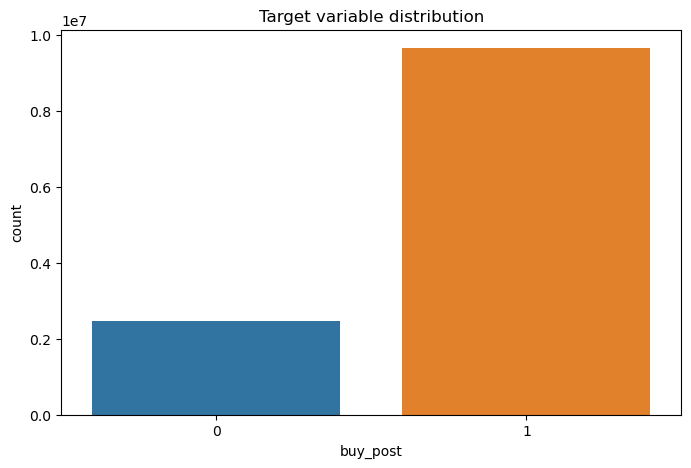

In [19]:
# Смотрю распределение целевой переменной buy_post
print(df['buy_post'].value_counts(normalize=True))
plt.figure(figsize=(8, 5))
sns.countplot(x='buy_post', data=df)
plt.title('Target variable distribution')
plt.show()

### Согласно комментарию по заданию: "0 (ноль если отток), 1 если НЕ отток"

Нужно сделат апсэмпл 0

In [20]:
# функция апсэмплинга:

from sklearn.utils import resample

def dataset_upsampling(df, feature_name):
    df_1 = df[df[feature_name] == 1]
    df_0  = df[df[feature_name] == 0]
    df_0_upsample = resample(df_0, replace=True, n_samples=len(df_1), random_state=42)
    df_upsampled = pd.concat([df_1, df_0_upsample])
    print(df_upsampled[feature_name].value_counts(normalize=True))
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature_name, data=df_upsampled)
    plt.title('Target variable distribution after upsampling')
    plt.show()
    return df_upsampled

buy_post
1    0.5
0    0.5
Name: proportion, dtype: float64


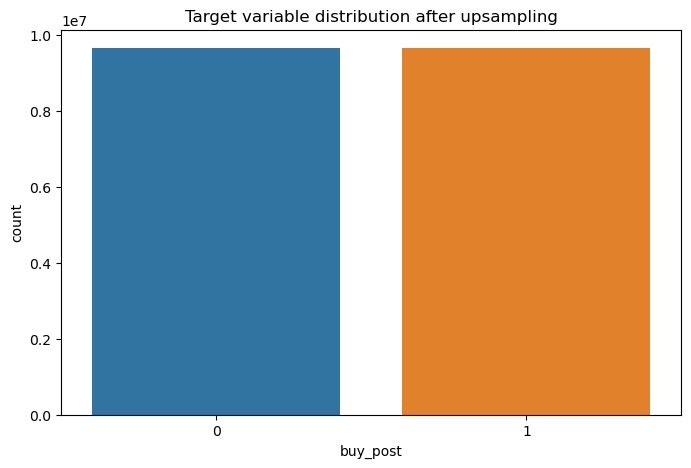

19321734

In [21]:
df_upsampled = dataset_upsampling(df, 'buy_post')

len(df_upsampled)

### Регрессия: прогноз дней до покупки

**Features**

In [22]:
# Лояльность
counts = df_upsampled['customer_id'].value_counts()
df_upsampled["loyality"] = df_upsampled['customer_id'].apply(lambda x: counts.loc[x])

In [23]:
# Производные от даты
df_upsampled["datetime"] = pd.to_datetime(df_upsampled["startdatetime"], format='mixed')
df_upsampled["day_of_week"] = df_upsampled["datetime"].dt.dayofweek
df_upsampled["hour_of_day"] = df_upsampled["datetime"].dt.hour
df_upsampled["month"] = df_upsampled["datetime"].dt.month
df_upsampled["quarter"] = df_upsampled["datetime"].dt.quarter

In [24]:
# Укрупняем категорию Блюда
# Считаем количество вхождений каждой категории
category_counts = df_upsampled["dish_name"].value_counts()
# Заменяем редкие категории на Другое.
threshold = category_counts.median()  # Медиана как порог отсева
for i in range(len(category_counts)):
    if category_counts[i] < threshold:
        df_upsampled["dish_name"].replace(category_counts.index[i], "Другое", inplace=True)
len(df_upsampled["dish_name"].value_counts())

520

In [25]:
# Придумаем что-то с площадью
df_upsampled['ownareaall_sqm'].value_counts().head(50)

ownareaall_sqm
300.00    548029
100.00    376885
250.00    221559
400.00    139893
350.00    134676
102.00    128099
92.00     115664
80.00     113083
120.00    112662
110.00    110560
89.00      99877
320.00     91003
119.31     87543
296.00     87013
101.00     81386
367.40     79799
95.00      74846
116.00     73944
78.23      73393
200.00     73234
246.20     71802
140.00     71691
128.50     70885
90.00      70594
115.00     70372
269.90     69608
538.70     68341
359.90     68314
101.80     67720
113.00     67515
366.60     67306
295.00     66196
303.00     66021
244.50     65643
280.00     64998
340.10     64225
233.20     63581
101.60     63092
85.00      62143
260.00     60761
431.10     60401
98.00      59887
230.00     59381
115.46     59192
114.50     59041
81.00      57896
360.00     57829
330.80     57349
361.00     57321
338.90     57095
Name: count, dtype: int64

In [26]:
df_upsampled['ownareaall_sqm'].describe()

count    1.932173e+07
mean     2.148473e+02
std      1.227573e+02
min      0.000000e+00
25%      1.046700e+02
50%      2.062000e+02
75%      3.000000e+02
max      9.787000e+02
Name: ownareaall_sqm, dtype: float64

In [27]:
def fit_area(x):
    res = 0
    if x<105:
        res = 0
    elif x<207:
        res = 1
    elif x<301:
        res = 2
    else:
        res = 3
    return res

In [28]:
df_upsampled['ownareaall_sqm'] = df_upsampled['ownareaall_sqm'].apply(fit_area)
df_upsampled['ownareaall_sqm'].value_counts()

ownareaall_sqm
2    5312003
0    4868150
1    4819900
3    4321681
Name: count, dtype: int64

In [29]:
df_test = df_upsampled[df_upsampled['date_diff_post'].isna()]

In [30]:
df_test.drop('date_diff_post', axis=1, inplace=True)

In [31]:
df_test.head()

,customer_id,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,loyality,datetime,day_of_week,hour_of_day,month,quarter
22486412,37024094,0,74.99,2023-04-05 19:18:30,Чизбургер,1,Отдельно стоящий с внешней зоной,65,2023-04-05 19:18:30,2,19,4,2
22567273,37259054,0,159.98,2022-12-06 20:17:26,Ord.2 сырных соуса,2,Отдельно стоящий без внешней зоны,165,2022-12-06 20:17:26,1,20,12,4
23479889,40744014,0,99.65,2023-03-04 14:04:04,"Эвервесс Лемон-Лайм б/л мал 0,4",3,Отдельно стоящий без внешней зоны,71,2023-03-04 14:04:04,5,14,3,1
18087318,27888583,0,85.02,2023-02-23 17:48:29,Up Кинг Наггетс Стандартный,0,Фудкорт без туалета,174,2023-02-23 17:48:29,3,17,2,1
1379413,1569718,0,239.99,2023-01-02 15:28:44,Другое,0,Фудкорт без туалета,58,2023-01-02 15:28:44,0,15,1,1


In [32]:
df = df_upsampled[~df_upsampled['date_diff_post'].isna()]

In [33]:
len(df) + len(df_test) == len(df_upsampled)

True

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [36]:
val, test = train_test_split(test, train_size=0.5, random_state=42)

In [37]:
train.columns

Index(['customer_id', 'date_diff_post', 'buy_post', 'revenue', 'startdatetime',
       'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'datetime',
       'day_of_week', 'hour_of_day', 'month', 'quarter'],
      dtype='object')

In [38]:
X = ['revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter'] # без целевой переменной date_diff_post
y = ['date_diff_post'] # целевая переменная
cat_features = ['dish_name', 'format_name', 'day_of_week', 'hour_of_day', 'month', 'quarter'] # категориальные признаки

In [43]:
parameters = {'cat_features': cat_features,
             'eval_metric': 'RMSE', # требуемая по заданию метрика RMSE
             'task_type': 'GPU',
             'learning_rate': 0.1,
             'iterations': 1000, # не хватило 1000 итераций
             'random_seed': 42,
             'verbose': 100}

In [44]:
from catboost import CatBoostRegressor

In [45]:
model_regr = CatBoostRegressor(**parameters)

In [46]:
model_regr.fit(train[X], train[y], eval_set=(val[X], val[y]))

0:	learn: 15.0435215	test: 15.0480972	best: 15.0480972 (0)	total: 624ms	remaining: 10m 23s
100:	learn: 13.8604401	test: 13.8667486	best: 13.8667486 (100)	total: 41.5s	remaining: 6m 9s
200:	learn: 13.8409713	test: 13.8470117	best: 13.8470117 (200)	total: 1m 20s	remaining: 5m 21s
300:	learn: 13.8278369	test: 13.8338059	best: 13.8338059 (300)	total: 1m 59s	remaining: 4m 37s
400:	learn: 13.8186900	test: 13.8245856	best: 13.8245856 (400)	total: 2m 39s	remaining: 3m 57s
500:	learn: 13.8109593	test: 13.8170261	best: 13.8170261 (500)	total: 3m 18s	remaining: 3m 17s
600:	learn: 13.8021444	test: 13.8083050	best: 13.8083050 (600)	total: 3m 59s	remaining: 2m 39s
700:	learn: 13.7950744	test: 13.8016750	best: 13.8016750 (700)	total: 4m 39s	remaining: 1m 59s
800:	learn: 13.7887166	test: 13.7952836	best: 13.7952836 (800)	total: 5m 18s	remaining: 1m 19s
900:	learn: 13.7827134	test: 13.7893199	best: 13.7893199 (900)	total: 5m 58s	remaining: 39.4s
999:	learn: 13.7768170	test: 13.7837068	best: 13.7837068 

In [47]:
test['pred_date_diff_post'] = model_regr.predict(test[X])  # Прогноз количества дней для метрики

In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
mse = mean_squared_error(test['date_diff_post'], test['pred_date_diff_post'])

In [50]:
rmse = np.sqrt(mse)
rmse

13.781180331516525

In [51]:
df_test['date_diff_post'] = model_regr.predict(df_test[X])  # Прогноз количества дней

In [52]:
df_ready = pd.concat([df, df_test])  # Объединяем две части датасета, где мы дополнили данные прогнозами

In [53]:
df_ready.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,loyality,datetime,day_of_week,hour_of_day,month,quarter
0,29891,9.0,1,69.99,2022-12-05 12:03:58,Кинг Фри станд,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
1,29891,9.0,1,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
2,29891,9.0,1,9.99,2022-12-05 12:03:58,Соус Сырный,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
3,29891,9.0,1,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
4,29891,9.0,1,119.99,2022-12-05 14:28:35,Латте (СТАНД.),2,Отдельно стоящий без внешней зоны,34,2022-12-05 14:28:35,0,14,12,4


In [54]:
len(df_ready) == len(df_upsampled)

True

In [55]:
check_missings(df_ready)

Total NA-values (всего пропусков) = 0


""
Total (всего пропусков)
Percent (процент пропусков)
Types (тип данных)


In [56]:
df_ready['date_diff_post'] = df_ready['date_diff_post'].round()

df_ready['date_diff_post'] = df_ready['date_diff_post'].astype(int)
df_ready

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,loyality,datetime,day_of_week,hour_of_day,month,quarter
0,29891,9,1,69.99,2022-12-05 12:03:58,Кинг Фри станд,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
1,29891,9,1,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
2,29891,9,1,9.99,2022-12-05 12:03:58,Соус Сырный,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
3,29891,9,1,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,2,Отдельно стоящий без внешней зоны,34,2022-12-05 12:03:58,0,12,12,4
4,29891,9,1,119.99,2022-12-05 14:28:35,Латте (СТАНД.),2,Отдельно стоящий без внешней зоны,34,2022-12-05 14:28:35,0,14,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19569829,29492499,23,0,69.99,2023-06-28 17:43:17,Гамбургер,0,Фудкорт без туалета,419,2023-06-28 17:43:17,2,17,6,2
13744681,22797677,11,0,49.99,2022-12-11 11:55:19,Маффин,1,Фудкорт с туалетом,727,2022-12-11 11:55:19,6,11,12,4
1238516,1391233,14,0,200.00,2023-06-23 12:10:18,Воппер,1,Фудкорт без туалета,69,2023-06-23 12:10:18,4,12,6,2
17040206,26411145,15,0,70.03,2023-05-27 15:03:29,Наггетсы (3 шт.),2,Отдельно стоящий без внешней зоны,75,2023-05-27 15:03:29,5,15,5,2


In [57]:
# Поменяем все данные из df_ready по дням на прогнозные
df_ready['date_diff_post'] = model_regr.predict(df_ready[X])

### Классификация: прогноз оттока

In [58]:
train, test = train_test_split(df_ready, train_size=0.8, random_state=42, stratify=df_ready['buy_post'])

In [59]:
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['buy_post'])

In [60]:
train.columns

Index(['customer_id', 'date_diff_post', 'buy_post', 'revenue', 'startdatetime',
       'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'datetime',
       'day_of_week', 'hour_of_day', 'month', 'quarter'],
      dtype='object')

In [61]:
X = ['date_diff_post', 'revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter'] # без целевой переменной date_diff_post
cat_features = ['dish_name', 'format_name', 'day_of_week', 'hour_of_day', 'month', 'quarter']

y = ['buy_post']

In [62]:
from catboost import CatBoostClassifier

In [63]:
params = {
        'eval_metric': 'F1', # требуемая по заданию метрика F1
        'verbose': 100,
        'random_state': 42,
        'learning_rate': 0.01,
        'task_type': 'GPU',
        'iterations': 500,
        'cat_features': cat_features
}

In [64]:
model_clf = CatBoostClassifier(**params)

In [ ]:
model_clf.fit(train[X], train[y], eval_set=(val[X], val[y]))

0:	learn: 0.7390469	test: 0.7389839	best: 0.7389839 (0)	total: 1.03s	remaining: 8m 35s
100:	learn: 0.7446052	test: 0.7450119	best: 0.7450119 (100)	total: 1m 26s	remaining: 5m 42s
200:	learn: 0.7482788	test: 0.7485793	best: 0.7485793 (200)	total: 2m 52s	remaining: 4m 17s
300:	learn: 0.7504331	test: 0.7506404	best: 0.7506404 (300)	total: 4m 31s	remaining: 2m 59s
400:	learn: 0.7520298	test: 0.7521830	best: 0.7521830 (400)	total: 6m 9s	remaining: 1m 31s


In [ ]:
model_clf.get_feature_importance(prettified=True)

In [ ]:
test['pred_buy_post'] = model_clf.predict(test[X])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report

In [ ]:
f1_score(test['buy_post'], test['pred_buy_post'])

In [ ]:
roc_auc_score(test['buy_post'], test['pred_buy_post'])

In [ ]:
# вроде бы на QA что-то звучало про macro

print(classification_report(test['buy_post'], test['pred_buy_post']))

In [ ]:
from catboost.utils import get_roc_curve

In [ ]:
from catboost import Pool

test_data = Pool(data=test[X],
                label=test[y],
                cat_features=cat_features)

In [ ]:
get_roc_curve(model_clf, test_data, plot=True);

# Работа с тестовым датасетом

In [ ]:
test_df = pd.read_parquet('hackaton2023_test.parquet')

In [ ]:
test_df.head()

In [ ]:
len(test_df)

In [ ]:
test_df.drop('group_name', axis=1, inplace=True)

In [ ]:
#Добавить фичи в тест
counts = test_df['customer_id'].value_counts()
test_df["loyality"] = test_df['customer_id'].apply(lambda x: counts.loc[x])

In [ ]:
# Производные от даты
test_df["datetime"] = pd.to_datetime(test_df["startdatetime"], format='mixed')
test_df["day_of_week"] = test_df["datetime"].dt.dayofweek
test_df["hour_of_day"] = test_df["datetime"].dt.hour
test_df["month"] = test_df["datetime"].dt.month
test_df["quarter"] = test_df["datetime"].dt.quarter

In [ ]:
# Укрупняем категорию Блюда
# Считаем количество вхождений каждой категории
category_counts = test_df["dish_name"].value_counts()
# Заменяем редкие категории на Другое.
threshold = category_counts.median()  # Медиана как порог отсева
for i in range(len(category_counts)):
    if category_counts[i] < threshold:
        test_df["dish_name"].replace(category_counts.index[i], "Другое", inplace=True)
len(test_df["dish_name"].value_counts())

In [ ]:
test_df['ownareaall_sqm'] = test_df['ownareaall_sqm'].apply(fit_area)
test_df['ownareaall_sqm'].value_counts()

In [ ]:
X = ['revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter'] # без целевой переменной date_diff_post
cat_features = ['dish_name', 'format_name', 'day_of_week', 'hour_of_day', 'month', 'quarter']
y = ['buy_post']

In [ ]:
test_df["date_diff_post"] = model_regr.predict(test_df[X])
test_df["date_diff_post"] = test_df["date_diff_post"].round().astype(int)

In [ ]:
test_df

In [ ]:
X = ['date_diff_post', 'revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter'] # без целевой переменной date_diff_post
cat_features = ['dish_name', 'format_name', 'day_of_week', 'hour_of_day', 'month', 'quarter']


y = ['buy_post']

In [ ]:
test_df["buy_post"] = model_clf.predict(test_df[X])

In [ ]:
final = test_df
final["datetime"] = pd.to_datetime(test_df["startdatetime"], format='mixed')
final = final.sort_values(by='datetime', ascending=False).groupby('customer_id').head(1)
#final = final.loc[final.groupby('customer_id')['datetime'].transform(max) == final['datetime']]
#final = final.sort_values(by='datetime', ascending=True)
#final = df.groupby('customer_id').head(1)

#final = test_df.loc[test_df.groupby('customer_id')['startdatetime'].transform(max) == test_df['startdatetime']]

In [ ]:
final['customer_id'].nunique()

In [ ]:
# Выгружаем в файл
submission = final[['customer_id','date_diff_post','buy_post']]
submission.to_csv('submission05.csv', sep=";")